STEP 1: Extract Useful data and generate labels

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bearings = {
    '35Hz12kN': ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5'],
    '37.5Hz11kN': ['Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5'],
    '40Hz10kN': ['Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5']
}

data_dir = os.path.join(os.getcwd(), 'data')
save_dir = os.path.join(os.getcwd(), 'extracted_data')

dataframes = {}
rul_labels = {}

for folder, bearings_list in bearings.items():
    folder_path = os.path.join(data_dir, folder)

    for bearing in bearings_list:
        bearing_path = os.path.join(folder_path, bearing)

        data_files = [os.path.join(bearing_path, f) for f in os.listdir(bearing_path) if f.endswith('.csv')]
        
        if data_files:
            try:
                data_files.sort()
                
                bearing_df = pd.concat([pd.read_csv(data_file) for data_file in data_files], ignore_index=True)
                dataframes[bearing] = bearing_df
                num_files = len(data_files)
                
                bearing_rul_labels = []

                for i, data_file in enumerate(data_files):
                    current_rul = num_files - i
                    samples_in_file = len(pd.read_csv(data_file))
                    
                    rul_for_file = np.full(samples_in_file, current_rul)
                    bearing_rul_labels.extend(rul_for_file)
                
                rul_labels[bearing] = bearing_rul_labels
                time_column = np.linspace(0, 60 * len(data_files), len(bearing_df), endpoint=False)  # Time in seconds
                bearing_df['Time'] = time_column
                bearing_df['RUL'] = bearing_rul_labels[:len(bearing_df)]

                # Save DataFrame to CSV
                bearing_df.to_csv(f'{save_dir}/{bearing}_with_labels.csv', index=False)
                print(f"CSV file created for: {bearing}")

            except Exception as e:
                print(f"Error reading files for {bearing}: {e}")
        else:
            print(f"No CSV files found for {bearing} in {bearing_path}")


CSV file created for: Bearing1_1
CSV file created for: Bearing1_2
CSV file created for: Bearing1_3
CSV file created for: Bearing1_4
CSV file created for: Bearing1_5
CSV file created for: Bearing2_1
CSV file created for: Bearing2_2
CSV file created for: Bearing2_3
CSV file created for: Bearing2_4
CSV file created for: Bearing2_5
CSV file created for: Bearing3_1
CSV file created for: Bearing3_2
CSV file created for: Bearing3_3
CSV file created for: Bearing3_4
CSV file created for: Bearing3_5


STEP 2: Visualize Data

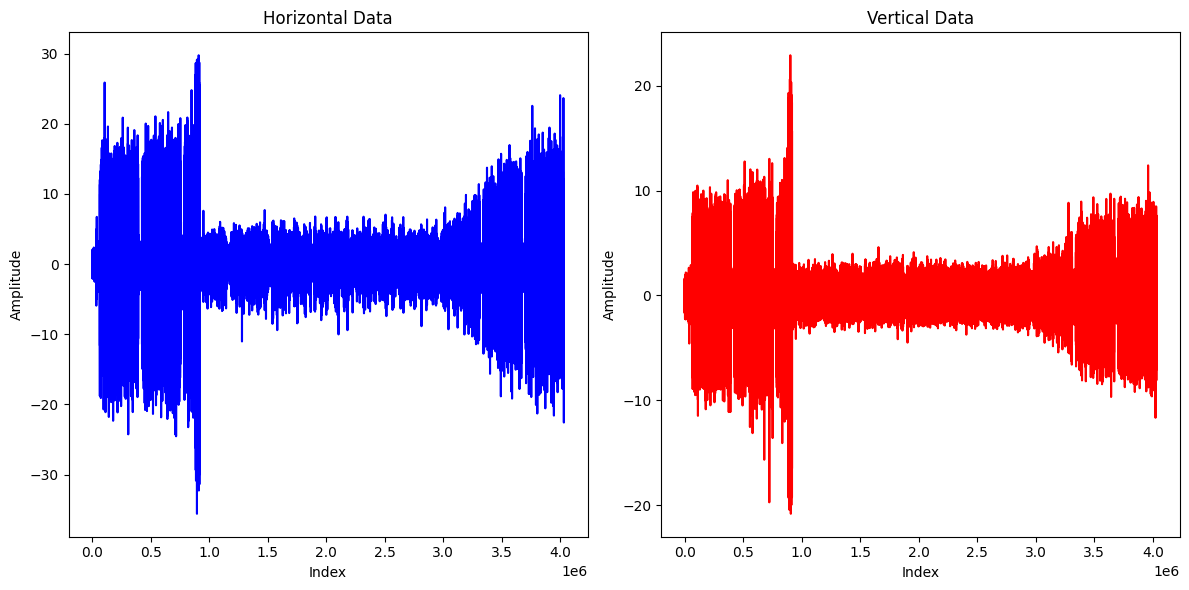

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

bearing = 'Bearing1_1'
save_dir = 'extracted_data'

df = pd.read_csv(f'{save_dir}/{bearing}_with_labels.csv')

horizontal_data = df['Horizontal_vibration_signals'].values
vertical_data = df['Vertical_vibration_signals'].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(horizontal_data, color='blue')
ax1.set_title('Horizontal Data')
ax1.set_xlabel('Index')
ax1.set_ylabel('Amplitude')

ax2.plot(vertical_data, color='red')
ax2.set_title('Vertical Data')
ax2.set_xlabel('Index')
ax2.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


STEP 3: Find sigma for Gaussian Filter

/home/ustc15/.local/lib/python3.10/site-packages/scipy/ndimage/_filters.py:235: RuntimeWarning: divide by zero encountered in scalar divide
  phi_x = np.exp(-0.5 / sigma2 * x ** 2)
/home/ustc15/.local/lib/python3.10/site-packages/scipy/ndimage/_filters.py:235: RuntimeWarning: invalid value encountered in multiply
  phi_x = np.exp(-0.5 / sigma2 * x ** 2)


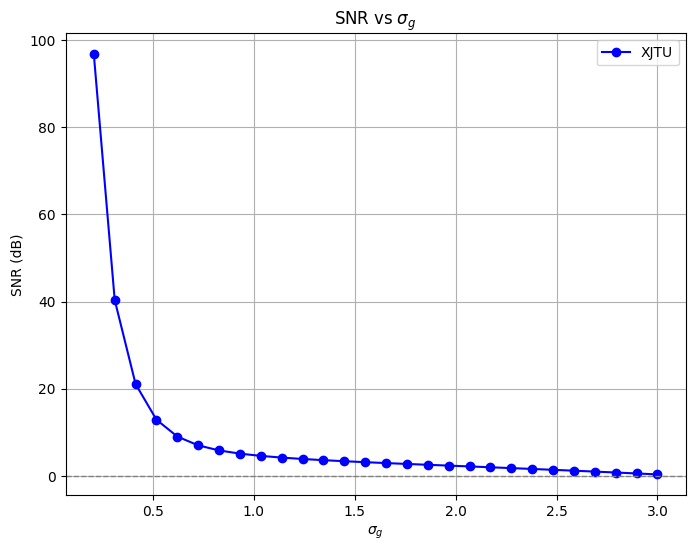

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

bearing = 'Bearing1_1'
data_dir = 'extracted_data'

df = pd.read_csv(f'{data_dir}/{bearing}_with_labels.csv')

# Extract two signals
signalA = df['Horizontal_vibration_signals'].values

# Define sigma values
sigma_values = np.linspace(0, 3, 30)
snr_A = []

# Compute SNR for both signals
for sigma in sigma_values:
    smoothed_A = gaussian_filter1d(signalA, sigma=sigma)

    signal_power_A = np.var(smoothed_A)
    noise_power_A = np.var(signalA - smoothed_A)
    snr_A.append(10 * np.log10(signal_power_A / noise_power_A) if noise_power_A > 0 else np.nan)


# Convert lists to NumPy arrays
sigma_values = np.array(sigma_values)
snr_A = np.array(snr_A)

# Interpolate to find where SNR crosses zero
def find_zero_crossing(sigma_vals, snr_vals):
    """Finds sigma where SNR crosses zero using linear interpolation."""
    for i in range(len(snr_vals) - 1):
        if snr_vals[i] * snr_vals[i + 1] < 0:  # Zero crossing detected
            f_interp = interp1d(snr_vals[i:i+2], sigma_vals[i:i+2])
            return f_interp(0)  # Estimate sigma where SNR = 0
    return None  # No zero crossing found

sigma_zero_A = find_zero_crossing(sigma_values, snr_A)

# Plot SNR curves
plt.figure(figsize=(8, 6))
plt.plot(sigma_values, snr_A, marker='o', linestyle='-', color='b', label='XJTU')

# Labels and title
plt.xlabel(r"$\sigma_{g}$")
plt.ylabel('SNR (dB)')
plt.title(r'SNR vs $\sigma_{g}$ ')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Add horizontal zero line
plt.legend()
plt.grid(True)
plt.show()


STEP 4: Apply Gaussian Filter with sigma

In [ ]:
from scipy.ndimage import gaussian_filter1d
import pandas as pd


bearings = {'Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5',
            'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 
            'Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5' }

sigma = 0.75   # Standard deviation of the Gaussian kernel
save_dir = 'extracted_data'
save_dir_filter = 'filter_data'

for bearing in bearings:
    try:
        df = pd.read_csv(f'{save_dir}/{bearing}_with_labels.csv')

        signalA = df['Horizontal_vibration_signals'].values
        signalB = df['Vertical_vibration_signals'].values
        rul = df['RUL'].values

        # Apply Gaussian filter
        smoothed_signalA = gaussian_filter1d(signalA, sigma=sigma)
        smoothed_signalB = gaussian_filter1d(signalB, sigma=sigma)

        smooth_df = pd.DataFrame()
        smooth_df['Horizontal'] = smoothed_signalA
        smooth_df['Vertical'] = smoothed_signalB
        smooth_df['RUL'] = rul

        # Save DataFrame to CSV
        # smooth_df.to_csv(f'{save_dir_filter}/Smooth_{bearing}.csv', index=False)
        print(f"CSV file with smoothed signals created for: {bearing}")

    except Exception as e:
        print(f"Error processing {bearing}: {e}")

print("All bearings processed.")


CSV file with smoothed signals created for: Bearing1_4
CSV file with smoothed signals created for: Bearing2_4
CSV file with smoothed signals created for: Bearing3_3
CSV file with smoothed signals created for: Bearing1_5
CSV file with smoothed signals created for: Bearing1_2
CSV file with smoothed signals created for: Bearing3_1
CSV file with smoothed signals created for: Bearing3_5
CSV file with smoothed signals created for: Bearing1_3
CSV file with smoothed signals created for: Bearing1_1
CSV file with smoothed signals created for: Bearing2_1
CSV file with smoothed signals created for: Bearing2_2
CSV file with smoothed signals created for: Bearing3_2
CSV file with smoothed signals created for: Bearing2_3
CSV file with smoothed signals created for: Bearing2_5
CSV file with smoothed signals created for: Bearing3_4
All bearings processed.


STEP 5: Visualize Filtered Data

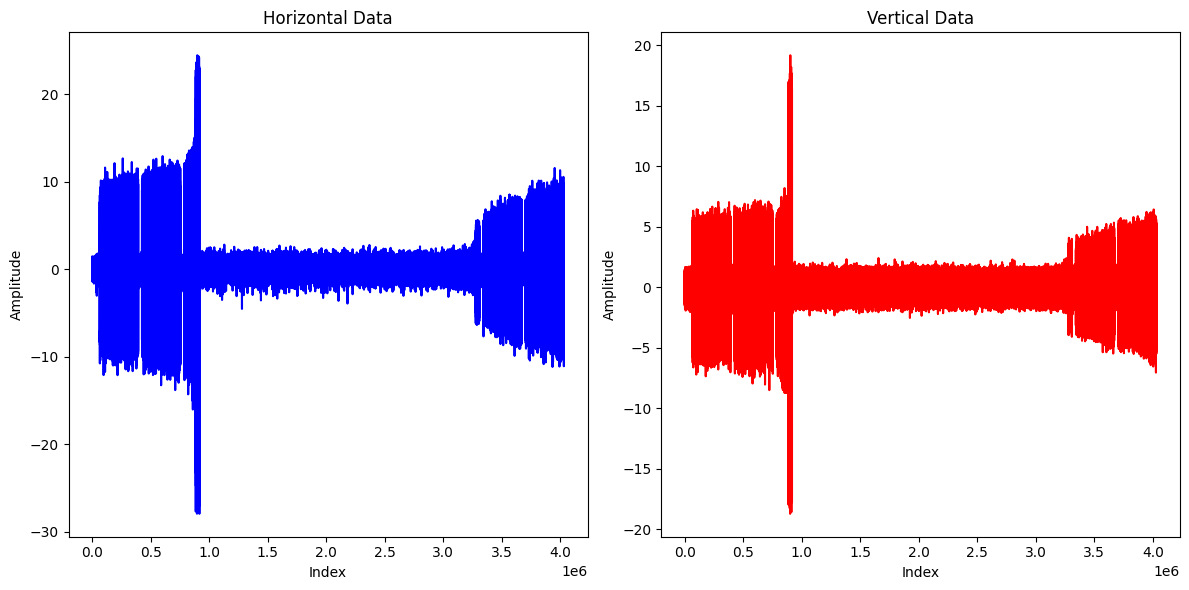

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

bearing = 'Bearing1_1'
data_dir = 'filter_data'

df = pd.read_csv(f'{data_dir}/Smooth_{bearing}.csv')

horizontal_data = df['Horizontal'].values
vertical_data = df['Vertical'].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(horizontal_data, color='blue')
ax1.set_title('Horizontal Data')
ax1.set_xlabel('Index')
ax1.set_ylabel('Amplitude')

ax2.plot(vertical_data, color='red')
ax2.set_title('Vertical Data')
ax2.set_xlabel('Index')
ax2.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

STEP 5: Extract TF features via Wavelet Transform

In [ ]:
import os
import pandas as pd
import numpy as np
import pywt
from scipy.stats import entropy, kurtosis, skew


bearings = {'Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5',
            'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 
            'Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5' }


input_folder = 'filter_data'
output_folder = 'tf_features'

# Signal specifications
fs = 25600  # Sampling frequency (Hz)
delta_t = 1 / fs  # Sampling interval (s)
f_min = 10  # Minimum frequency of interest (Hz)
f_max = 120  # Maximum frequency of interest (Hz)
f_c = 0.81  # Central frequency of Morlet wavelet

# Calculate scale limits
s_min = f_c / (f_max * delta_t)
s_max = f_c / (f_min * delta_t)

# Generate scales
num_scales = 100
scales = np.logspace(np.log10(s_min), np.log10(s_max), num_scales)

for bearing in bearings:

    df = pd.read_csv(f'{input_folder}/Smooth_{bearing}.csv')

    signalARms = df['Horizontal'].values
    signalBRms = df['Vertical'].values
    rul = df['RUL'].values

    wavelet = 'cmor'

    window_size = 1000
    step_size = 500

    # Prepare DataFrame
    data = []

    for start in range(0, len(signalARms) - window_size, step_size):
        window_signal1 = signalARms[start:start + window_size]
        window_signal2 = signalBRms[start:start + window_size]
        
        coeff1, freq1 = pywt.cwt(window_signal1, scales, wavelet, sampling_period=1/fs)
        coeff2, freq2 = pywt.cwt(window_signal2, scales, wavelet, sampling_period=1/fs)
        
        # Energy: Sum of squared coefficients
        energy1 = np.sum(np.abs(coeff1) ** 2)
        energy2 = np.sum(np.abs(coeff2) ** 2)
        
        # Dominant frequency: Scale with maximum energy
        dominant_scale1 = np.argmax(np.sum(np.abs(coeff1) ** 2, axis=1))
        dominant_scale2 = np.argmax(np.sum(np.abs(coeff2) ** 2, axis=1))
        dominant_frequency1 = freq1[dominant_scale1]
        dominant_frequency2 = freq2[dominant_scale2]
        
        # Entropy: Shannon entropy of the signal
        def calculate_entropy(signal):
            hist, bins = np.histogram(signal, bins=3, density=True)
            return entropy(hist + 1e-9)
        
        entropy1 = calculate_entropy(window_signal1)
        entropy2 = calculate_entropy(window_signal2)
        
        # Kurtosis and skewness
        kurtosis1 = kurtosis(window_signal1)
        kurtosis2 = kurtosis(window_signal2)
        skewness1 = skew(window_signal1)
        skewness2 = skew(window_signal2)
        
        # Mean and standard deviation
        mean1 = np.mean(window_signal1)
        mean2 = np.mean(window_signal2)
        std1 = np.std(window_signal1)
        std2 = np.std(window_signal2)
        
        # Feature vectors
        feature_vector1 = [energy1, dominant_frequency1, entropy1, kurtosis1, skewness1, mean1, std1]
        feature_vector2 = [energy2, dominant_frequency2, entropy2, kurtosis2, skewness2, mean2, std2]
        
        # RUL label
        center_index = start + window_size // 2
        rul_label = rul[center_index]
        
        # Append data row
        data.append({
            'Horizontal': feature_vector1,
            'Vertical': feature_vector2,
            'RUL': rul_label
        })

    # Convert to DataFrame
    df_features = pd.DataFrame(data)

    # Save to CSV
    output_file = f'{output_folder}/{bearing}_features.csv'
    df_features.to_csv(output_file, index=False)

    print(f"Features saved to {output_file}")


STEP 6: Visualize TF features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.preprocess import process_features


dfs = []
for i in range(1, 6):
    dfs.append(pd.read_csv(f'/home/ustc15/research/idea2/time_features/Bearing1_{i}_features_with_labels.csv'))

# Combine RUL arrays
rul = np.hstack([df['RUL'].values for df in dfs])
maxx = np.max(rul)
rul = rul / maxx

# Extract and process the 'Horizontal' columns
horizontal_data = [np.array(df['Horizontal'].apply(eval).tolist()) for df in dfs]

# Process features for horizontal data
processed_features = [process_features(data) for data in horizontal_data]

# Combine full feature sets
features_array_horizontal = np.vstack(processed_features)

# Select the first DataFrame
df = dfs[0]

# Extract and process the 'Horizontal' column
horizontal_data = np.array(df['Vertical'].apply(eval).tolist())

# Process features for horizontal data
processed_features = process_features(horizontal_data)

# Plotting the features
feature_names = [r"$E_{v}$", r"$f_{d_{v}}$", r"$h_{v}$", r"$k_{v}$", r"$sk_{v}$", r"$avg_{v}$", r"$\sigma_{v}$"]
num_features = processed_features.shape[1]
colors = plt.cm.inferno(np.linspace(0, 1, num_features))  # Reverting to the vibrant color palette

plt.figure(figsize=(13, 7))  # More compact image
# plt.style.use('seaborn-v0_8-deep')
for i in range(num_features):
    plt.subplot(num_features, 1, i+1)
    plt.grid()
    plt.plot(processed_features[:, i], label=feature_names[i], color=colors[i])
    plt.ylabel(feature_names[i])
    if i == num_features - 1:
        plt.xlabel('Frequency(Hz)')  # Only add x-axis label on the last subplot
    else:
        plt.xticks([])  # Hide x-ticks for all plots except the last one
    plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

STEP 7: Visualize RUL 

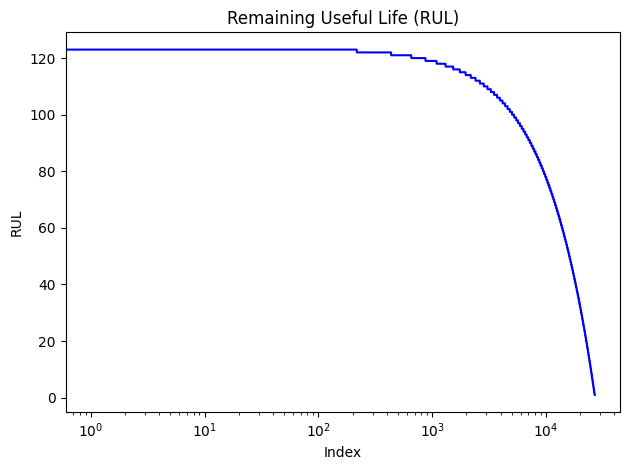

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

bearing = 'Bearing1_1'
data_dir = 'tf_features'

df = pd.read_csv(f'{data_dir}/{bearing}_features.csv')

rul = df['RUL'].values

plt.plot(rul, color='blue')
plt.title('Remaining Useful Life (RUL)')
plt.xlabel('Index')
plt.xscale('log')
plt.ylabel('RUL')
plt.tight_layout()
plt.show()

STEP 4: Train CARLE

In [ ]:
import numpy as np
import pandas as pd
import json
from sklearn.utils import shuffle
from utils.preprocess import process_features
from utils.reset_callback import ResetStatesCallback
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.regularizers import l2
from keras._tf_keras.keras.optimizers import RMSprop
from keras._tf_keras.keras.callbacks import  EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras._tf_keras.keras.layers import Input, Conv1D, Dense,Activation,MultiHeadAttention, Add, BatchNormalization, Flatten, Dense, LSTM, MaxPooling1D


#directories for features and weights
feature_dir = 'tf_features'
weights_dir = 'model_weights'
stat_dir = 'statistics'

#CARLE
input_shape = (14, 1)
convH = Input(shape=input_shape)

# Define regularization strength
reg_strength = 0.005

# First Conv Block with Residual Connection
convh1 = Conv1D(256, 3, padding='same', kernel_regularizer=l2(reg_strength))(convH)
convh1 = BatchNormalization()(convh1)
convh1 = Activation('relu')(convh1)
convh1 = MaxPooling1D(pool_size=1)(convh1)  # Adjust pooling size to maintain the same dimension

# Adjust input to match convh1 dimensions for residual connection
convH_adjusted = Conv1D(256, 1, padding='same', kernel_regularizer=l2(reg_strength))(convH)
res1 = Add()([convH_adjusted, convh1])

# Second Conv Block with Residual Connection
convh2 = Conv1D(256, 3, padding='same', kernel_regularizer=l2(reg_strength))(res1)
convh2 = BatchNormalization()(convh2)
convh2 = Activation('relu')(convh2)
convh2 = MaxPooling1D(pool_size=1)(convh2)  # Adjust pooling size to maintain the same dimension

# Adjust res1 to match convh2 dimensions for residual connection
res1_adjusted = Conv1D(256, 1, padding='same', kernel_regularizer=l2(reg_strength))(res1)
res2 = Add()([res1_adjusted, convh2])

# Third Conv Block with Residual Connection
convh3 = Conv1D(128, 2, padding='same', kernel_regularizer=l2(reg_strength))(res2)
convh3 = BatchNormalization()(convh3)
convh3 = Activation('relu')(convh3)
convh3 = MaxPooling1D(pool_size=1)(convh3)  # Adjust pooling size to maintain the same dimension

# Adjust res2 to match convh3 dimensions for residual connection
res2_adjusted = Conv1D(128, 1, padding='same', kernel_regularizer=l2(reg_strength))(res2)
res3 = Add()([res2_adjusted, convh3])

# Fourth Conv Block with Residual Connection
convh4 = Conv1D(64, 2, padding='same', kernel_regularizer=l2(reg_strength))(res3)
convh4 = BatchNormalization()(convh4)
convh4 = Activation('relu')(convh4)
convh4 = MaxPooling1D(pool_size=1)(convh4)  # Adjust pooling size to maintain the same dimension

# Adjust res3 to match convh4 dimensions for residual connection
res3_adjusted = Conv1D(64, 1, padding='same', kernel_regularizer=l2(reg_strength))(res3)
res4 = Add()([res3_adjusted, convh4])

# Multi-Head Attention layer
multi_head_attention_h = MultiHeadAttention(num_heads=8, key_dim=64)(res4, res4)

# First LSTM Block with Residual Connection
lstm1 = LSTM(64, activation='relu', stateful=False, return_sequences=True)(multi_head_attention_h)
multi_head_attention_h = MultiHeadAttention(num_heads=8, key_dim=64)(lstm1, lstm1)

# Residual connection
res5 = Add()([multi_head_attention_h, lstm1])

# Second LSTM Block with Residual Connection
lstm2 = LSTM(64, activation='relu', stateful=False, return_sequences=True)(res5)
multi_head_attention_h = MultiHeadAttention(num_heads=8, key_dim=64)(lstm2, lstm2)

# Residual connection
res6 = Add()([res5, multi_head_attention_h])

# Flatten and Dense layers
flat = Flatten()(res6)
dense = Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(flat)
dense = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(dense)
dense = Dense(32, activation='relu', kernel_regularizer=l2(reg_strength))(dense)
output = Dense(1)(dense)

# Model definition
model = Model(inputs=convH, outputs=output)
model.summary()


# Compile the model
model.compile(optimizer=RMSprop(learning_rate=1e-5), loss='mse', metrics=['mae'])


bearings = ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5']

# Read all CSV files dynamically based on bearing names
dfs = [pd.read_csv(f'{feature_dir}/{bearing}_features.csv') for bearing in bearings]
labels = np.concatenate([df['RUL'].values / np.max(df['RUL'].values) for df in dfs])

horizontal_data = [np.array(df['Horizontal'].apply(eval).tolist()) for df in dfs]
X_h = np.vstack([process_features(data) for data in horizontal_data])

vertical_data = [np.array(df['Vertical'].apply(eval).tolist()) for df in dfs]
X_v = np.vstack([process_features(data) for data in vertical_data])

# Concatenate both horizontal and vertical features
X_time_series = np.concatenate((X_h, X_v), axis=-1)

# Shuffle data
X_time_series, labels = shuffle(X_time_series, labels, random_state=42)



reset_states_callback = ResetStatesCallback()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-10)
checkpoint_callback = ModelCheckpoint(f'{weights_dir}/xjtu_CARLE_weights.keras', monitor='loss', save_best_only=True, mode='min')



# Train the model
history = model.fit(
    X_time_series, labels,
    epochs=250, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[reset_states_callback, early_stopping_callback, reduce_lr_callback, checkpoint_callback]
)

pd.DataFrame(history.history).to_csv(f'{stat_dir}/xjtu_CARLE_training_history.csv', index=False)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 14, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 14, 256)   │      1,024 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 256)   │      1,024 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 14, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 14, 256)   │        512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 14, 256)   │          0 │ activation_4[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 14, 256)   │          0 │ conv1d_9[0][0],   │
│                     │                   │            │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 14, 256)   │    196,864 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 256)   │      1,024 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 14, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 14, 256)   │     65,792 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 14, 256)   │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 14, 256)   │          0 │ conv1d_11[0][0],  │
│                     │                   │            │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 14, 128)   │     65,664 │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 128)   │        512 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 14, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 14, 128)   │     32,896 │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 14, 128)   │          0 │ activation_6[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 14, 128)   │          0 │ conv1d_13[0][0],

 Total params: 979,521 (3.74 MB)

 Trainable params: 978,113 (3.73 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - loss: 6.7774 - mae: 0.3019 - val_loss: 5.9681 - val_mae: 0.2461
Epoch 2/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 45s 67ms/step - loss: 5.7417 - mae: 0.2388 - val_loss: 5.1368 - val_mae: 0.2288
Epoch 3/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 45s 67ms/step - loss: 4.9794 - mae: 0.2181 - val_loss: 4.5801 - val_mae: 0.2021
Epoch 4/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - loss: 4.4689 - mae: 0.1913 - val_loss: 4.1727 - val_mae: 0.1785
Epoch 5/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 45s 66ms/step - loss: 4.0877 - mae: 0.1794 - val_loss: 3.8610 - val_mae: 0.2096


STEP 10: Visualize Training Statistics

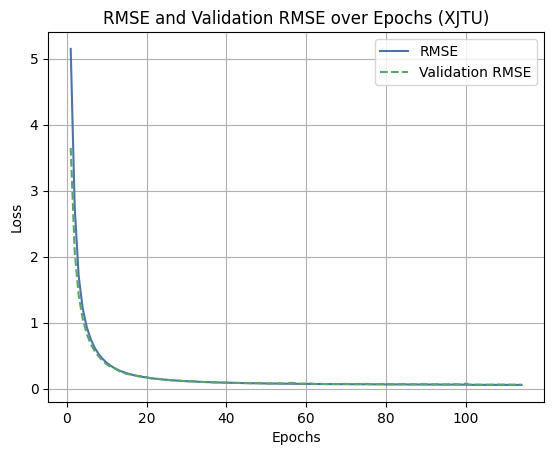

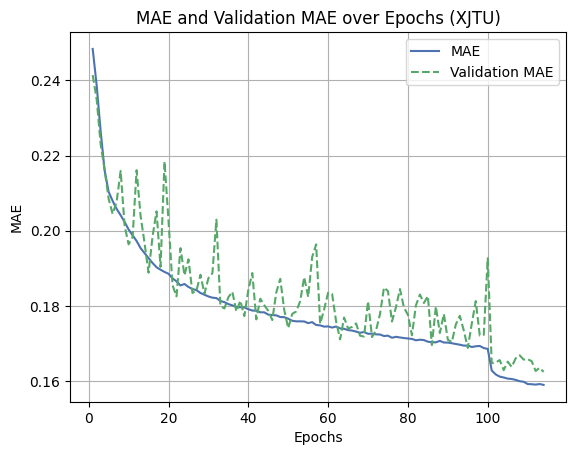

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


# Read CSV file
dir = os.getcwd()
stats_dir = os.path.join(dir, 'statistics')

df = pd.read_csv(f'{stats_dir}/xjtu_CARLE_training_history.csv')

# Extract loss and validation loss
loss = df['loss'].values
val_loss = df['val_loss'].values
MAE = df['mae'].values
val_MAE = df['val_mae'].values
epochs = np.arange(1, len(loss) + 1)

plt.style.use('seaborn-v0_8-deep')
# Plot loss and validation loss
plt.plot(epochs, loss, label="RMSE", linestyle='-')
plt.plot(epochs, val_loss, label="Validation RMSE", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("RMSE and Validation RMSE over Epochs (XJTU)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, MAE, label="MAE", linestyle='-')
plt.plot(epochs, val_MAE, label="Validation MAE", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("MAE and Validation MAE over Epochs (XJTU)")
plt.legend()
plt.grid(True)
plt.show()


STEP 11: Ensemble Training

In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from utils.preprocess import process_features
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.regularizers import l2
from sklearn.ensemble import RandomForestRegressor
from keras._tf_keras.keras.layers import Input, Conv1D, Dense,Activation,MultiHeadAttention, Add, BatchNormalization, Flatten, Dense, LSTM, MaxPooling1D



bearings = ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5']


feature_dir = 'tf_features'
weights_dir = 'model_weights'
reg_strength = 0.005

# Input layer
input_shape = (14, 1)
convH = Input(shape=input_shape)
convh1 = Conv1D(256, 3, padding='same', kernel_regularizer=l2(reg_strength))(convH)
convh1 = BatchNormalization()(convh1)
convh1 = Activation('relu')(convh1)
convh1 = MaxPooling1D(pool_size=1)(convh1)  # Adjust pooling size to maintain the same dimension

# Adjust input to match convh1 dimensions for residual connection
convH_adjusted = Conv1D(256, 1, padding='same', kernel_regularizer=l2(reg_strength))(convH)
res1 = Add()([convH_adjusted, convh1])

# Second Conv Block with Residual Connection
convh2 = Conv1D(256, 3, padding='same', kernel_regularizer=l2(reg_strength))(res1)
convh2 = BatchNormalization()(convh2)
convh2 = Activation('relu')(convh2)
convh2 = MaxPooling1D(pool_size=1)(convh2)  # Adjust pooling size to maintain the same dimension

# Adjust res1 to match convh2 dimensions for residual connection
res1_adjusted = Conv1D(256, 1, padding='same', kernel_regularizer=l2(reg_strength))(res1)
res2 = Add()([res1_adjusted, convh2])

# Third Conv Block with Residual Connection
convh3 = Conv1D(128, 2, padding='same', kernel_regularizer=l2(reg_strength))(res2)
convh3 = BatchNormalization()(convh3)
convh3 = Activation('relu')(convh3)
convh3 = MaxPooling1D(pool_size=1)(convh3)  # Adjust pooling size to maintain the same dimension

# Adjust res2 to match convh3 dimensions for residual connection
res2_adjusted = Conv1D(128, 1, padding='same', kernel_regularizer=l2(reg_strength))(res2)
res3 = Add()([res2_adjusted, convh3])

# Fourth Conv Block with Residual Connection
convh4 = Conv1D(64, 2, padding='same', kernel_regularizer=l2(reg_strength))(res3)
convh4 = BatchNormalization()(convh4)
convh4 = Activation('relu')(convh4)
convh4 = MaxPooling1D(pool_size=1)(convh4)  # Adjust pooling size to maintain the same dimension

# Adjust res3 to match convh4 dimensions for residual connection
res3_adjusted = Conv1D(64, 1, padding='same', kernel_regularizer=l2(reg_strength))(res3)
res4 = Add()([res3_adjusted, convh4])

# Multi-Head Attention layer
multi_head_attention_h = MultiHeadAttention(num_heads=8, key_dim=64)(res4, res4)

# First LSTM Block with Residual Connection
lstm1 = LSTM(64, activation='relu', stateful=False, return_sequences=True)(multi_head_attention_h)
multi_head_attention_h = MultiHeadAttention(num_heads=8, key_dim=64)(lstm1, lstm1)

# Residual connection
res5 = Add()([multi_head_attention_h, lstm1])

# Second LSTM Block with Residual Connection
lstm2 = LSTM(64, activation='relu', stateful=False, return_sequences=True)(res5)
multi_head_attention_h = MultiHeadAttention(num_heads=8, key_dim=64)(lstm2, lstm2)

# Residual connection
res6 = Add()([res5, multi_head_attention_h])

# Flatten and Dense layers
flat = Flatten()(res6)
dense = Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(flat)
dense = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(dense)
dense = Dense(32, activation='relu', kernel_regularizer=l2(reg_strength))(dense)
output = Dense(1)(dense)

# Model definition
model = Model(inputs=convH, outputs=output)

model.load_weights(f'{weights_dir}/xjtu_CARLE_weights.h5')

# Read all CSV files dynamically based on bearing names
dfs = [pd.read_csv(f'{feature_dir}/{bearing}_features.csv') for bearing in bearings]
labels = np.concatenate([df['RUL'].values / np.max(df['RUL'].values) for df in dfs])

horizontal_data = [np.array(df['Horizontal'].apply(eval).tolist()) for df in dfs]
X_h = np.vstack([process_features(data) for data in horizontal_data])

vertical_data = [np.array(df['Vertical'].apply(eval).tolist()) for df in dfs]
X_v = np.vstack([process_features(data) for data in vertical_data])

# Concatenate both horizontal and vertical features
X_time_series = np.concatenate((X_h, X_v), axis=-1)
X_time_series, labels = shuffle(X_time_series, labels, random_state=42)

feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)  # Change index to select the layer
X_train_features = feature_extractor.predict(X_time_series)

regressor = RandomForestRegressor(n_estimators=800, random_state=42)
regressor.fit(X_train_features, labels)

# save
with open(f'{weights_dir}/xjtu_CARLE_skl.pkl','wb') as f:
    pickle.dump(regressor,f)


2025-05-28 10:45:10.810048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 10:45:10.810940: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 10:45:10.813664: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 10:45:10.821537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748400310.834659   19198 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748400310.83

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step


STEP 12: Ablation experiments

2025-09-09 10:12:31.210196: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 10:12:31.211120: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 10:12:31.213832: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 10:12:31.221267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757383951.234049   16066 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757383951.23

840/840 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step
840/840 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step
840/840 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step
840/840 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
3352/3352 ━━━━━━━━━━━━━━━━━━━━ 73s 22ms/step
3352/3352 ━━━━━━━━━━━━━━━━━━━━ 71s 21ms/step
3352/3352 ━━━━━━━━━━━━━━━━━━━━ 47s 14m

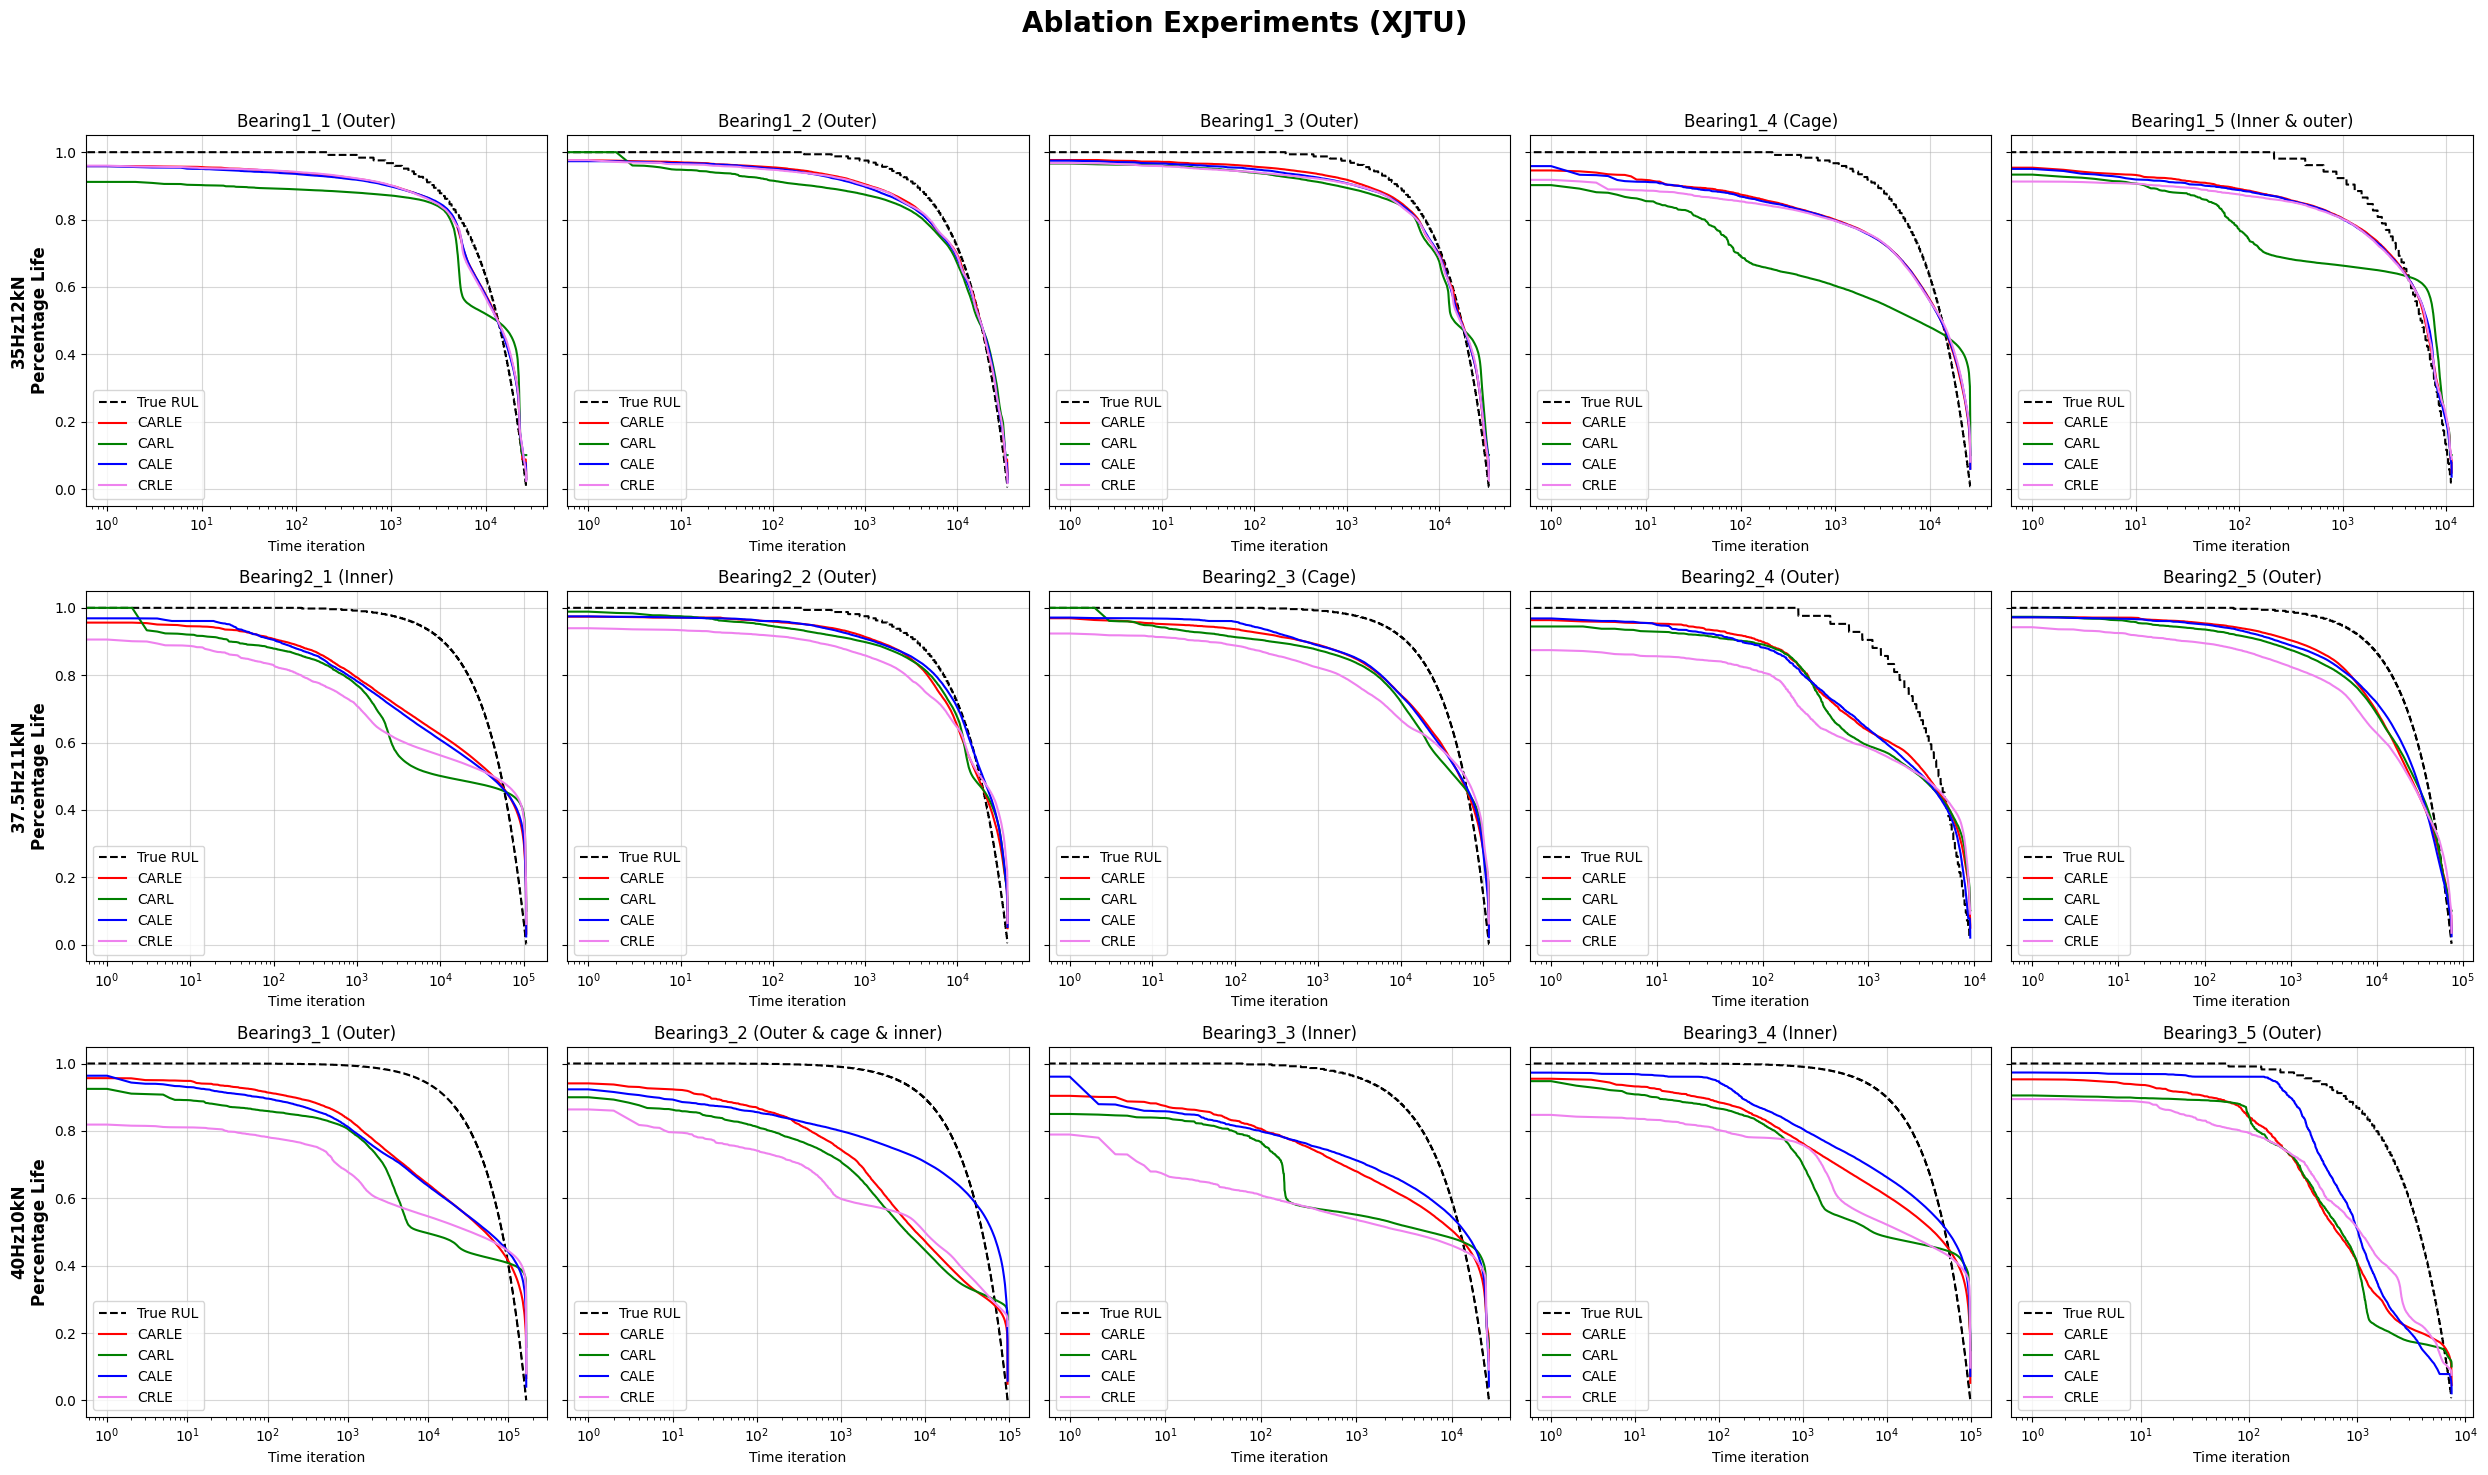

Idea 1: Ablation experiments results have been saved.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model, load_model
from utils.preprocess import process_features
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from ablation_CARLE import CARLE, CALE, CRLE


def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def score(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)
    error = y_pred - y_true

    # Masks
    mask_early = error < 0   # early prediction
    mask_late = error >= 0   # late prediction

    # Apply penalties
    score_early = np.sum((np.exp(-error / 13) - 1) * mask_early)
    score_late = np.sum((np.exp(error / 10) - 1) * mask_late)

    return score_early + score_late


bearings = {
    '35Hz12kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer'},
        {'name': 'Bearing1_2', 'failure': 'Outer'},
        {'name': 'Bearing1_3', 'failure': 'Outer'},
        {'name': 'Bearing1_4', 'failure': 'Cage'},
        {'name': 'Bearing1_5', 'failure': 'Inner & outer'},
    ],
    '37.5Hz11kN': [
        {'name': 'Bearing2_1', 'failure': 'Inner'},
        {'name': 'Bearing2_2', 'failure': 'Outer'},
        {'name': 'Bearing2_3', 'failure': 'Cage'},
        {'name': 'Bearing2_4', 'failure': 'Outer'},
        {'name': 'Bearing2_5', 'failure': 'Outer'},
    ],
    '40Hz10kN': [
        {'name': 'Bearing3_1', 'failure': 'Outer'},
        {'name': 'Bearing3_2', 'failure': 'Outer & cage & inner'},
        {'name': 'Bearing3_3', 'failure': 'Inner'},
        {'name': 'Bearing3_4', 'failure': 'Inner'},
        {'name': 'Bearing3_5', 'failure': 'Outer'},
    ]
}


# Load directories
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')

carle_keras = CARLE()
carle_keras.load_weights(f'{weights_dir}/xjtu_CARLE_weights.h5')
carle_extractor = Model(inputs=carle_keras.input, outputs=carle_keras.get_layer(index=-2).output)
carle_regressor = joblib.load(f'{weights_dir}/xjtu_CARLE_skl.pkl')

cale_keras = CALE()
cale_keras.load_weights(f'{weights_dir}/xjtu_CALE_weights.h5')
cale_extractor = Model(inputs=cale_keras.input, outputs=cale_keras.get_layer(index=-2).output)
cale_regressor = joblib.load(f'{weights_dir}/xjtu_CALE_skl.pkl')

crle_keras = CRLE()
crle_keras.load_weights(f'{weights_dir}/xjtu_CRLE_weights.h5')
crle_extractor = Model(inputs=crle_keras.input, outputs=crle_keras.get_layer(index=-2).output)
crle_regressor = joblib.load(f'{weights_dir}/xjtu_CRLE_skl.pkl')



error_data = []

# Prepare subplots
plt.style.use('seaborn-v0_8-deep')
rows = len(bearings)
columns = max(len(bearing_list) for bearing_list in bearings.values())  # Max number of bearings in any condition
fig, axes = plt.subplots(rows, columns, figsize=(25, 5 * rows), sharey=True)
fig.suptitle('Ablation Experiments (XJTU)', fontsize=20, fontweight='bold')

# Loop through conditions and bearings
for row, (condition, bearing_list) in enumerate(bearings.items()):
    for col in range(columns):
        if col < len(bearing_list):  # Populate only for existing bearings
            bearing_info = bearing_list[col]
            bearing = bearing_info['name']
            failure = bearing_info['failure']

            try:
                df = pd.read_csv(f'{feature_dir}/{bearing}_features.csv')

                horizontal_features = np.array(df['Horizontal'].apply(eval).tolist())
                xh = process_features(horizontal_features)
                vertical_features = np.array(df['Vertical'].apply(eval).tolist())
                xv = process_features(vertical_features)
                X = np.concatenate([xh, xv], axis=1)

                y_true = df['RUL'].values / np.max(df['RUL'].values)

                carle_X = carle_extractor.predict(X).squeeze()
                cale_X = cale_extractor.predict(X).squeeze()
                crle_X = crle_extractor.predict(X).squeeze()

                pred_carle = carle_regressor.predict(carle_X).squeeze()
                pred_carl = carle_keras.predict(X).squeeze()
                pred_carl = np.clip(pred_carl, 0, 1)
                pred_cale = cale_regressor.predict(cale_X).squeeze()
                pred_crle = crle_regressor.predict(crle_X).squeeze()

                pred_carle = np.sort(pred_carle.squeeze())[::-1]
                pred_carl = np.sort(pred_carl.squeeze())[::-1]
                pred_cale = np.sort(pred_cale.squeeze())[::-1]
                pred_crle = np.sort(pred_crle.squeeze())[::-1]

            
                # Compute errors and store in list
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "CARLE",
                    "Mean Squared Error": mean_squared_error(y_true, pred_carle),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_carle),
                    "Score": score(y_true, pred_carle)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "CARL",
                    "Mean Squared Error": mean_squared_error(y_true, pred_carl),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_carl),
                    "Score": score(y_true, pred_carl)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "CALE",
                    "Mean Squared Error": mean_squared_error(y_true, pred_cale),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_cale),
                    "Score": score(y_true, pred_cale)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "CRLE",
                    "Mean Squared Error": mean_squared_error(y_true, pred_crle),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_crle),
                    "Score": score(y_true, pred_crle)
                })

                axes[row, col].plot(y_true, label='True RUL', color='black', linestyle='--')
                axes[row, col].plot(pred_carle, label='CARLE', color='red', linestyle='-')
                axes[row, col].plot(pred_carl, label='CARL', color='green', linestyle='-')
                axes[row, col].plot(pred_cale, label='CALE', color='blue', linestyle='-')
                axes[row, col].plot(pred_crle, label='CRLE', color='violet', linestyle='-')

                axes[row, col].set_title(f'{bearing} ({failure})')
                axes[row, col].grid(alpha=0.5)
                axes[row, col].set_xscale('log')
                axes[row, col].legend(loc='best')
                axes[row, col].set_xlabel('Time iteration')
                if col == 0:  # Set ylabel for first column only
                    axes[row, col].set_ylabel(f'{condition}\nPercentage Life', fontsize=12, fontweight='bold')
            except Exception as e:
                print(f"Error processing {bearing}: {e}")
        else:  # Clear unused subplots
            axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

df_errors = pd.DataFrame(error_data)
df_errors.to_csv(f'{stats_dir}/xjtu_CARLE_ablation.csv', index=False)

print("Idea 1: Ablation experiments results have been saved.csv")

STEP 12: Comparison with State-of-the-art models

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from comparison import CNN_LSTM,CNN_BiLSTM,MSIDISN
from ablation_CARLE import CARLE
from utils.preprocess import process_features,correct_dims3
from keras._tf_keras.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Fixed missing imports


def score(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)
    error = y_pred - y_true

    # Masks
    mask_early = error < 0   # early prediction
    mask_late = error >= 0   # late prediction

    # Apply penalties
    score_early = np.sum((np.exp(-error / 13) - 1) * mask_early)
    score_late = np.sum((np.exp(error / 10) - 1) * mask_late)

    return score_early + score_late

bearings = {
    '35Hz12kN': ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5'],
    '37.5Hz11kN': ['Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5'],
    '40Hz10kN': ['Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5']
}


dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir,'statistics')

cnn_lstm = CNN_LSTM()
cnn_lstm.load_weights(f'{weights_dir}/cnn_lstm.h5')

cnn_bilstm = CNN_BiLSTM()
cnn_bilstm.load_weights(f'{weights_dir}/cnn_bilstm.h5')

msidin = MSIDISN()
msidin.load_weights(f'{weights_dir}/msidin.h5')

carle_keras = CARLE()
carle_keras.load_weights(f'{weights_dir}/xjtu_CARLE_weights.h5')
carle_extractor = Model(inputs=carle_keras.input, outputs=carle_keras.get_layer(index=-2).output)
carle_regressor = joblib.load(f'{weights_dir}/xjtu_CARLE_skl.pkl')

error_data = []

# Loop through conditions and bearings
for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
           df = pd.read_csv(f'{feature_dir}/{bearing}_features.csv')
           horizontal_features = np.array(df['Horizontal'].apply(eval).tolist())
           X_time_H = process_features(horizontal_features)
           vertical_features = np.array(df['Vertical'].apply(eval).tolist())
           X_time_V = process_features(vertical_features)
           y_true = df['RUL'].values / np.max(df['RUL'].values)
           X = np.concatenate((X_time_H, X_time_V), axis=-1)
           X = correct_dims3(X)
           pred_msidin = msidin.predict(X).squeeze()
           pred_cnn_lstm = cnn_lstm.predict(X).squeeze()
           pred_cnn_bilstm = cnn_bilstm.predict(X).squeeze()
           carle_logitX = carle_extractor.predict(X)
           pred_carle = carle_regressor.predict(carle_logitX).squeeze()

           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "CARLE",
                "Mean Squared Error": mean_squared_error(y_true, pred_carle),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_carle)
                "score": score(y_true, pred_carle)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "CNN-LSTM",
                "Mean Squared Error": mean_squared_error(y_true, pred_cnn_lstm),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_cnn_lstm)
                "score": score(y_true, pred_cnn_lstm)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "CABiLSTM",
                "Mean Squared Error": mean_squared_error(y_true, pred_cnn_bilstm),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_cnn_bilstm)
                "score": score(y_true, pred_cnn_bilstm)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "MSIDIN",
                "Mean Squared Error": mean_squared_error(y_true, pred_msidin),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_msidin)
                "score": score(y_true, pred_msidin)
            })
        except Exception as e:
            print(f"Error processing {bearing}: {e}")

# Convert error data to DataFrame and save as CSV grouped by condition
df_errors = pd.DataFrame(error_data)
df_errors.to_csv(f'{stats_dir}/xjtu_CARLE_SOTA.csv', index=False)

print("Idea 1: State-of-the-art models comparison saved (indluding score).csv")


2025-09-09 09:11:24.811787: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 09:11:24.812675: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 09:11:24.815533: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 09:11:24.823429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757380284.836553   28228 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757380284.84

840/840 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
840/840 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
840/840 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
840/840 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
3352/3352 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step
3352/3352 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3352/3352 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
3352/3352 ━━━━━━━━━━━━━

STEP 13: Explanations

2025-05-28 13:52:00.324166: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 13:52:00.325070: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 13:52:00.328183: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 13:52:00.336131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748411520.349876    9916 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748411520.35

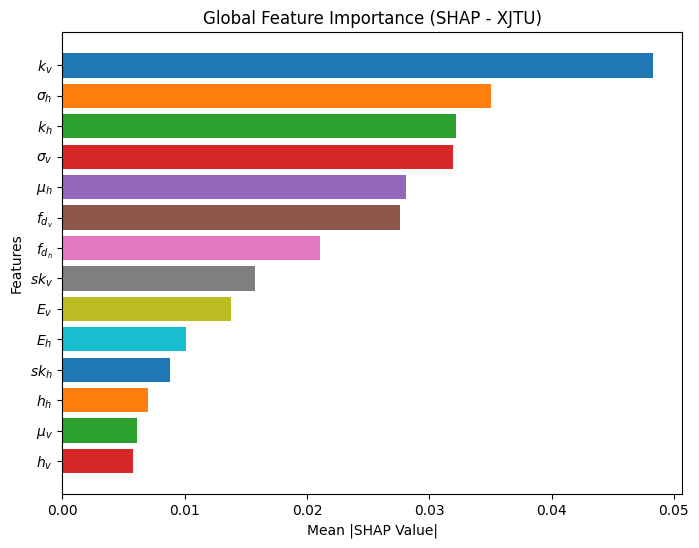

/tmp/ipykernel_9916/1695532577.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_subset, feature_names=X_names)


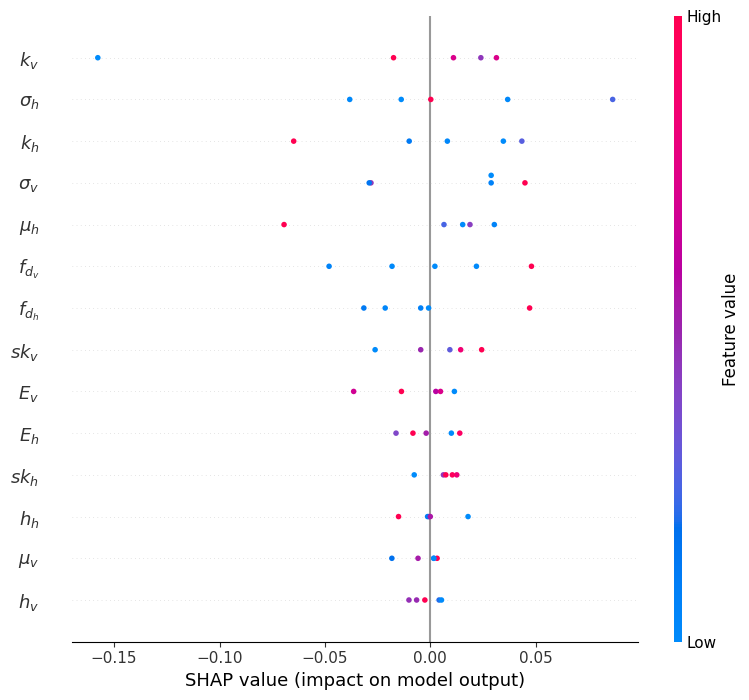

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # For color palettes
import pandas as pd
import joblib
import os
from utils.preprocess import process_features
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.models import load_model, Model
from utils.preprocess import correct_dims3
from ablation_models import CARLE

# Load model and feature extractor
dir = os.getcwd()
weights_dir = os.path.join(dir, 'model_weights')
time_dir = os.path.join(dir, 'tf_features')

model = CARLE()
model.load_weights(f'{weights_dir}/xjtu_CARLE_weights.h5')
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
regressor = joblib.load(f'{weights_dir}/xjtu_CARLE_skl.pkl')


# Load XJTU dataset
bearings = ['Bearing1_1','Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5',
            'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5',
            'Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5']

dfs = [pd.read_csv(f'{time_dir}/{bearing}_features.csv') for bearing in bearings]
y = np.concatenate([df['RUL'].values / np.max(df['RUL'].values) for df in dfs])

horizontal_data = [np.array(df['Horizontal'].apply(eval).tolist()) for df in dfs]
X_h = np.vstack([process_features(data) for data in horizontal_data])

vertical_data = [np.array(df['Vertical'].apply(eval).tolist()) for df in dfs]
X_v = np.vstack([process_features(data) for data in vertical_data])

# Combine horizontal and vertical features
X, y = shuffle(np.concatenate((X_h, X_v), axis=-1), y, random_state=42)
X = correct_dims3(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature names
X_names = [
    r"$E_{h}$", r"$f_{d_{h}}$", r"$h_{h}$", r"$k_{h}$", r"$sk_{h}$", r"$\mu_{h}$", r"$\sigma_{h}$",
    r"$E_{v}$", r"$f_{d_{v}}$", r"$h_{v}$", r"$k_{v}$", r"$sk_{v}$", r"$\mu_{v}$", r"$\sigma_{v}$"
]

# Define model prediction function
def full_model_predict(X):
    X_reshaped = X.reshape(X.shape[0], X_train.shape[1], X_train.shape[2])
    intermediate_output = feature_extractor.predict(X_reshaped,verbose=0)
    intermediate_output_flattened = intermediate_output.reshape(intermediate_output.shape[0], -1)
    return regressor.predict(intermediate_output_flattened)

# Flatten input for SHAP
X_flattened = X.reshape(X.shape[0], -1)

# Randomly select 500 samples for SHAP analysis
num_samples = 500
random_indices = np.random.choice(X_flattened.shape[0], num_samples, replace=False)
X_subset = X_flattened[random_indices]

# Initialize SHAP Explainer
explainer = shap.Explainer(full_model_predict, X_subset)

# Compute SHAP values on the subset
shap_values = explainer(X_subset)

# Compute mean absolute SHAP values per feature
feature_importances = np.abs(shap_values.values).mean(axis=0)

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
X_names_sorted = [X_names[i] for i in sorted_indices]
feature_importances_sorted = feature_importances[sorted_indices]

# Create color palette for sorted bars
colors = sns.color_palette("tab10", len(X_names_sorted))

# Plot global feature importance
plt.figure(figsize=(8, 6))
plt.barh(X_names_sorted, feature_importances_sorted, color=colors)
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Features')
plt.title('Global Feature Importance (SHAP - XJTU)')
plt.gca().invert_yaxis()
plt.show()

# SHAP Summary Plot (Only for 500 samples)
shap.summary_plot(shap_values, features=X_subset, feature_names=X_names)


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22

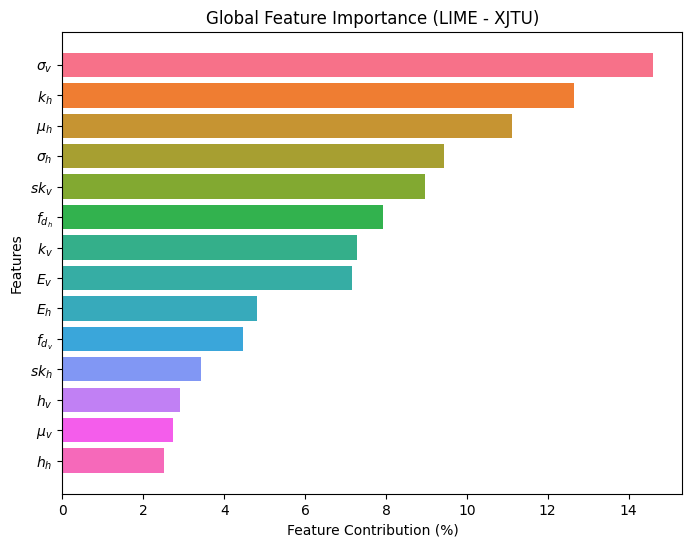

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.preprocess import process_features
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from ablation_CARLE import CARLE
from keras._tf_keras.keras.models import Model
import joblib
from utils.preprocess import correct_dims3
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns  # For color palettes


bearings = ['Bearing1_1','Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5',
            'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5',
            'Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5']

dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')



model = CARLE()
model.load_weights(f'{weights_dir}/xjtu_CARLE_weights.h5')
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
regressor = joblib.load(f'{weights_dir}/xjtu_CARLE_skl.pkl')


dfs = [pd.read_csv(f'{feature_dir}/{bearing}_features.csv') for bearing in bearings]
y = np.concatenate([df['RUL'].values / np.max(df['RUL'].values) for df in dfs])

horizontal_data = [np.array(df['Horizontal'].apply(eval).tolist()) for df in dfs]
X_h = np.vstack([process_features(data) for data in horizontal_data])

vertical_data = [np.array(df['Vertical'].apply(eval).tolist()) for df in dfs]
X_v = np.vstack([process_features(data) for data in vertical_data])

# Concatenate both horizontal and vertical features
X,y = shuffle(np.concatenate((X_h, X_v), axis=-1), y, random_state=42)
X = correct_dims3(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def full_model_predict(X):
    X_reshaped = X.reshape(X.shape[0], X_train.shape[1], X_train.shape[2])
    intermediate_output = feature_extractor.predict(X_reshaped)
    intermediate_output_flattened = intermediate_output.reshape(intermediate_output.shape[0], -1)
    return regressor.predict(intermediate_output_flattened)

# Feature names
X_names = [
    r"$E_{h}$", r"$f_{d_{h}}$", r"$h_{h}$", r"$k_{h}$", r"$sk_{h}$", r"$\mu_{h}$", r"$\sigma_{h}$",
    r"$E_{v}$", r"$f_{d_{v}}$", r"$h_{v}$", r"$k_{v}$", r"$sk_{v}$", r"$\mu_{v}$", r"$\sigma_{v}$"
]

# Flatten the input data for LIME compatibility
X_flattened = X.reshape(X.shape[0], -1)

# Initialize the LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_flattened,
    feature_names=X_names,
    mode='regression'
)

# Aggregate feature importances across all instances
feature_importances = np.zeros(len(X_names))

for i in range(500):
    explanation = explainer.explain_instance(
        X[np.random.randint(0,len(X))].flatten(),
        full_model_predict,  # Predict using the full model
        num_features=len(X_names)
    )
    
    # Accumulate the absolute contributions of features
    local_importance = dict(explanation.as_list())
    for feature, importance in local_importance.items():
        # Extract the feature name before any space or operator
        feature_cleaned = feature.split(' ')[0]
        if feature_cleaned in X_names:
            feature_idx = X_names.index(feature_cleaned)
            feature_importances[feature_idx] += abs(importance)

# Normalize the feature importances to percentages
feature_importances_percentage = (feature_importances / feature_importances.sum()) * 100

# Sort the features by importance
sorted_indices = np.argsort(feature_importances_percentage)[::-1]  # Sort in descending order
X_names_sorted = [X_names[i] for i in sorted_indices]
feature_importances_sorted = feature_importances_percentage[sorted_indices]

# Create a color palette for the sorted bars
colors = sns.color_palette("husl", len(X_names_sorted))

# Plot global feature importance
plt.figure(figsize=(8, 6))
plt.barh(X_names_sorted, feature_importances_sorted, color=colors)
plt.xlabel('Feature Contribution (%)')
plt.ylabel('Features')
plt.title('Global Feature Importance (LIME - XJTU)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


Local Feature Importance

/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


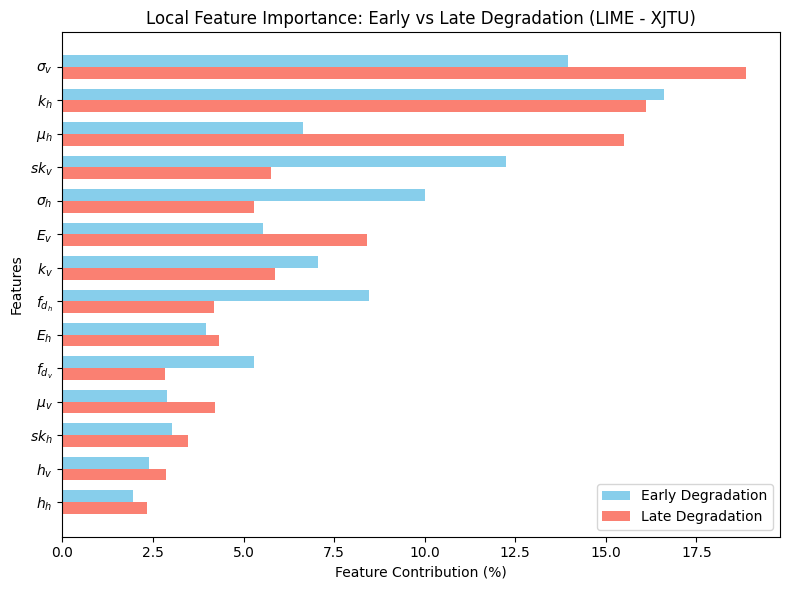

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.preprocess import process_features, correct_dims3
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from ablation_CARLE import CARLE
from keras._tf_keras.keras.models import Model
import joblib
import lime
import lime.lime_tabular
import seaborn as sns  # For color palettes

bearings = ['Bearing1_1','Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5',
            'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5',
            'Bearing3_1', 'Bearing3_2', 'Bearing3_3', 'Bearing3_4', 'Bearing3_5']

dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')

model = CARLE()
model.load_weights(f'{weights_dir}/xjtu_CARLE_weights.h5')
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
regressor = joblib.load(f'{weights_dir}/xjtu_CARLE_skl.pkl')

dfs = [pd.read_csv(os.path.join(feature_dir, f'{bearing}_features.csv')) for bearing in bearings]
y = np.concatenate([df['RUL'].values / np.max(df['RUL'].values) for df in dfs])

horizontal_data = [np.array(df['Horizontal'].apply(eval).tolist()) for df in dfs]
X_h = np.vstack([process_features(data) for data in horizontal_data])

vertical_data = [np.array(df['Vertical'].apply(eval).tolist()) for df in dfs]
X_v = np.vstack([process_features(data) for data in vertical_data])

# Concatenate features and shuffle
X, y = shuffle(np.concatenate((X_h, X_v), axis=-1), y, random_state=42)
X = correct_dims3(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------- 5. Prediction function ----------
def full_model_predict(X_input):
    X_reshaped = X_input.reshape(X_input.shape[0], X_train.shape[1], X_train.shape[2])
    intermediate_output = feature_extractor.predict(X_reshaped)
    intermediate_output_flat = intermediate_output.reshape(intermediate_output.shape[0], -1)
    return regressor.predict(intermediate_output_flat)

X_names = [
    r"$E_{h}$", r"$f_{d_{h}}$", r"$h_{h}$", r"$k_{h}$", r"$sk_{h}$", r"$\mu_{h}$", r"$\sigma_{h}$",
    r"$E_{v}$", r"$f_{d_{v}}$", r"$h_{v}$", r"$k_{v}$", r"$sk_{v}$", r"$\mu_{v}$", r"$\sigma_{v}$"
]

# Flatten data for LIME
X_flattened = X.reshape(X.shape[0], -1)

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_flattened,
    feature_names=X_names,
    mode='regression'
)

early_mask = y >= 0.9   # first 10% of life
late_mask = y <= 0.1    # last 10% of life

X_early = X[early_mask].reshape(-1, X_train.shape[1]*X_train.shape[2])
X_late = X[late_mask].reshape(-1, X_train.shape[1]*X_train.shape[2])

# ---------- 9. Function to compute LIME global feature importance ----------
def lime_feature_importance(X_subset, num_samples=10):
    feature_importances = np.zeros(len(X_names))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X_subset))
        explanation = explainer.explain_instance(
            X_subset[idx].flatten(),
            full_model_predict,
            num_features=len(X_names)
        )
        local_importance = dict(explanation.as_list())
        for feature, importance in local_importance.items():
            feature_cleaned = feature.split(' ')[0]
            if feature_cleaned in X_names:
                feature_importances[X_names.index(feature_cleaned)] += abs(importance)
    return (feature_importances / feature_importances.sum()) * 100  # percentages

early_importance = lime_feature_importance(X_early)
late_importance = lime_feature_importance(X_late)

# ---------- 10. Sort features by combined importance ----------
combined_importance = early_importance + late_importance
sorted_indices = np.argsort(combined_importance)[::-1]  # descending order

features_sorted = [X_names[i] for i in sorted_indices]
early_sorted = early_importance[sorted_indices]
late_sorted = late_importance[sorted_indices]

# ---------- 11. Vertical (horizontal bars) plot ----------
plt.figure(figsize=(8, 6))
x = np.arange(len(features_sorted))
width = 0.35

plt.barh(x - width/2, early_sorted, height=width, label='Early Degradation', color='skyblue')
plt.barh(x + width/2, late_sorted, height=width, label='Late Degradation', color='salmon')
plt.yticks(x, features_sorted)
plt.xlabel('Feature Contribution (%)')
plt.ylabel('Features')
plt.title('Local Feature Importance: Early vs Late Degradation (LIME - XJTU)')
plt.gca().invert_yaxis()  # highest contribution at the top
plt.legend()
plt.tight_layout()
plt.show()


NOISE Experiment

2025-09-09 13:19:56.657710: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 13:19:56.746789: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 13:19:57.059923: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 13:19:57.188359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757395197.312242   31748 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757395197.33

/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step
840/840 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step
840/840 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
3352/3352 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step
3352/3352 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step
3352/3352 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 80s 22ms/step
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 

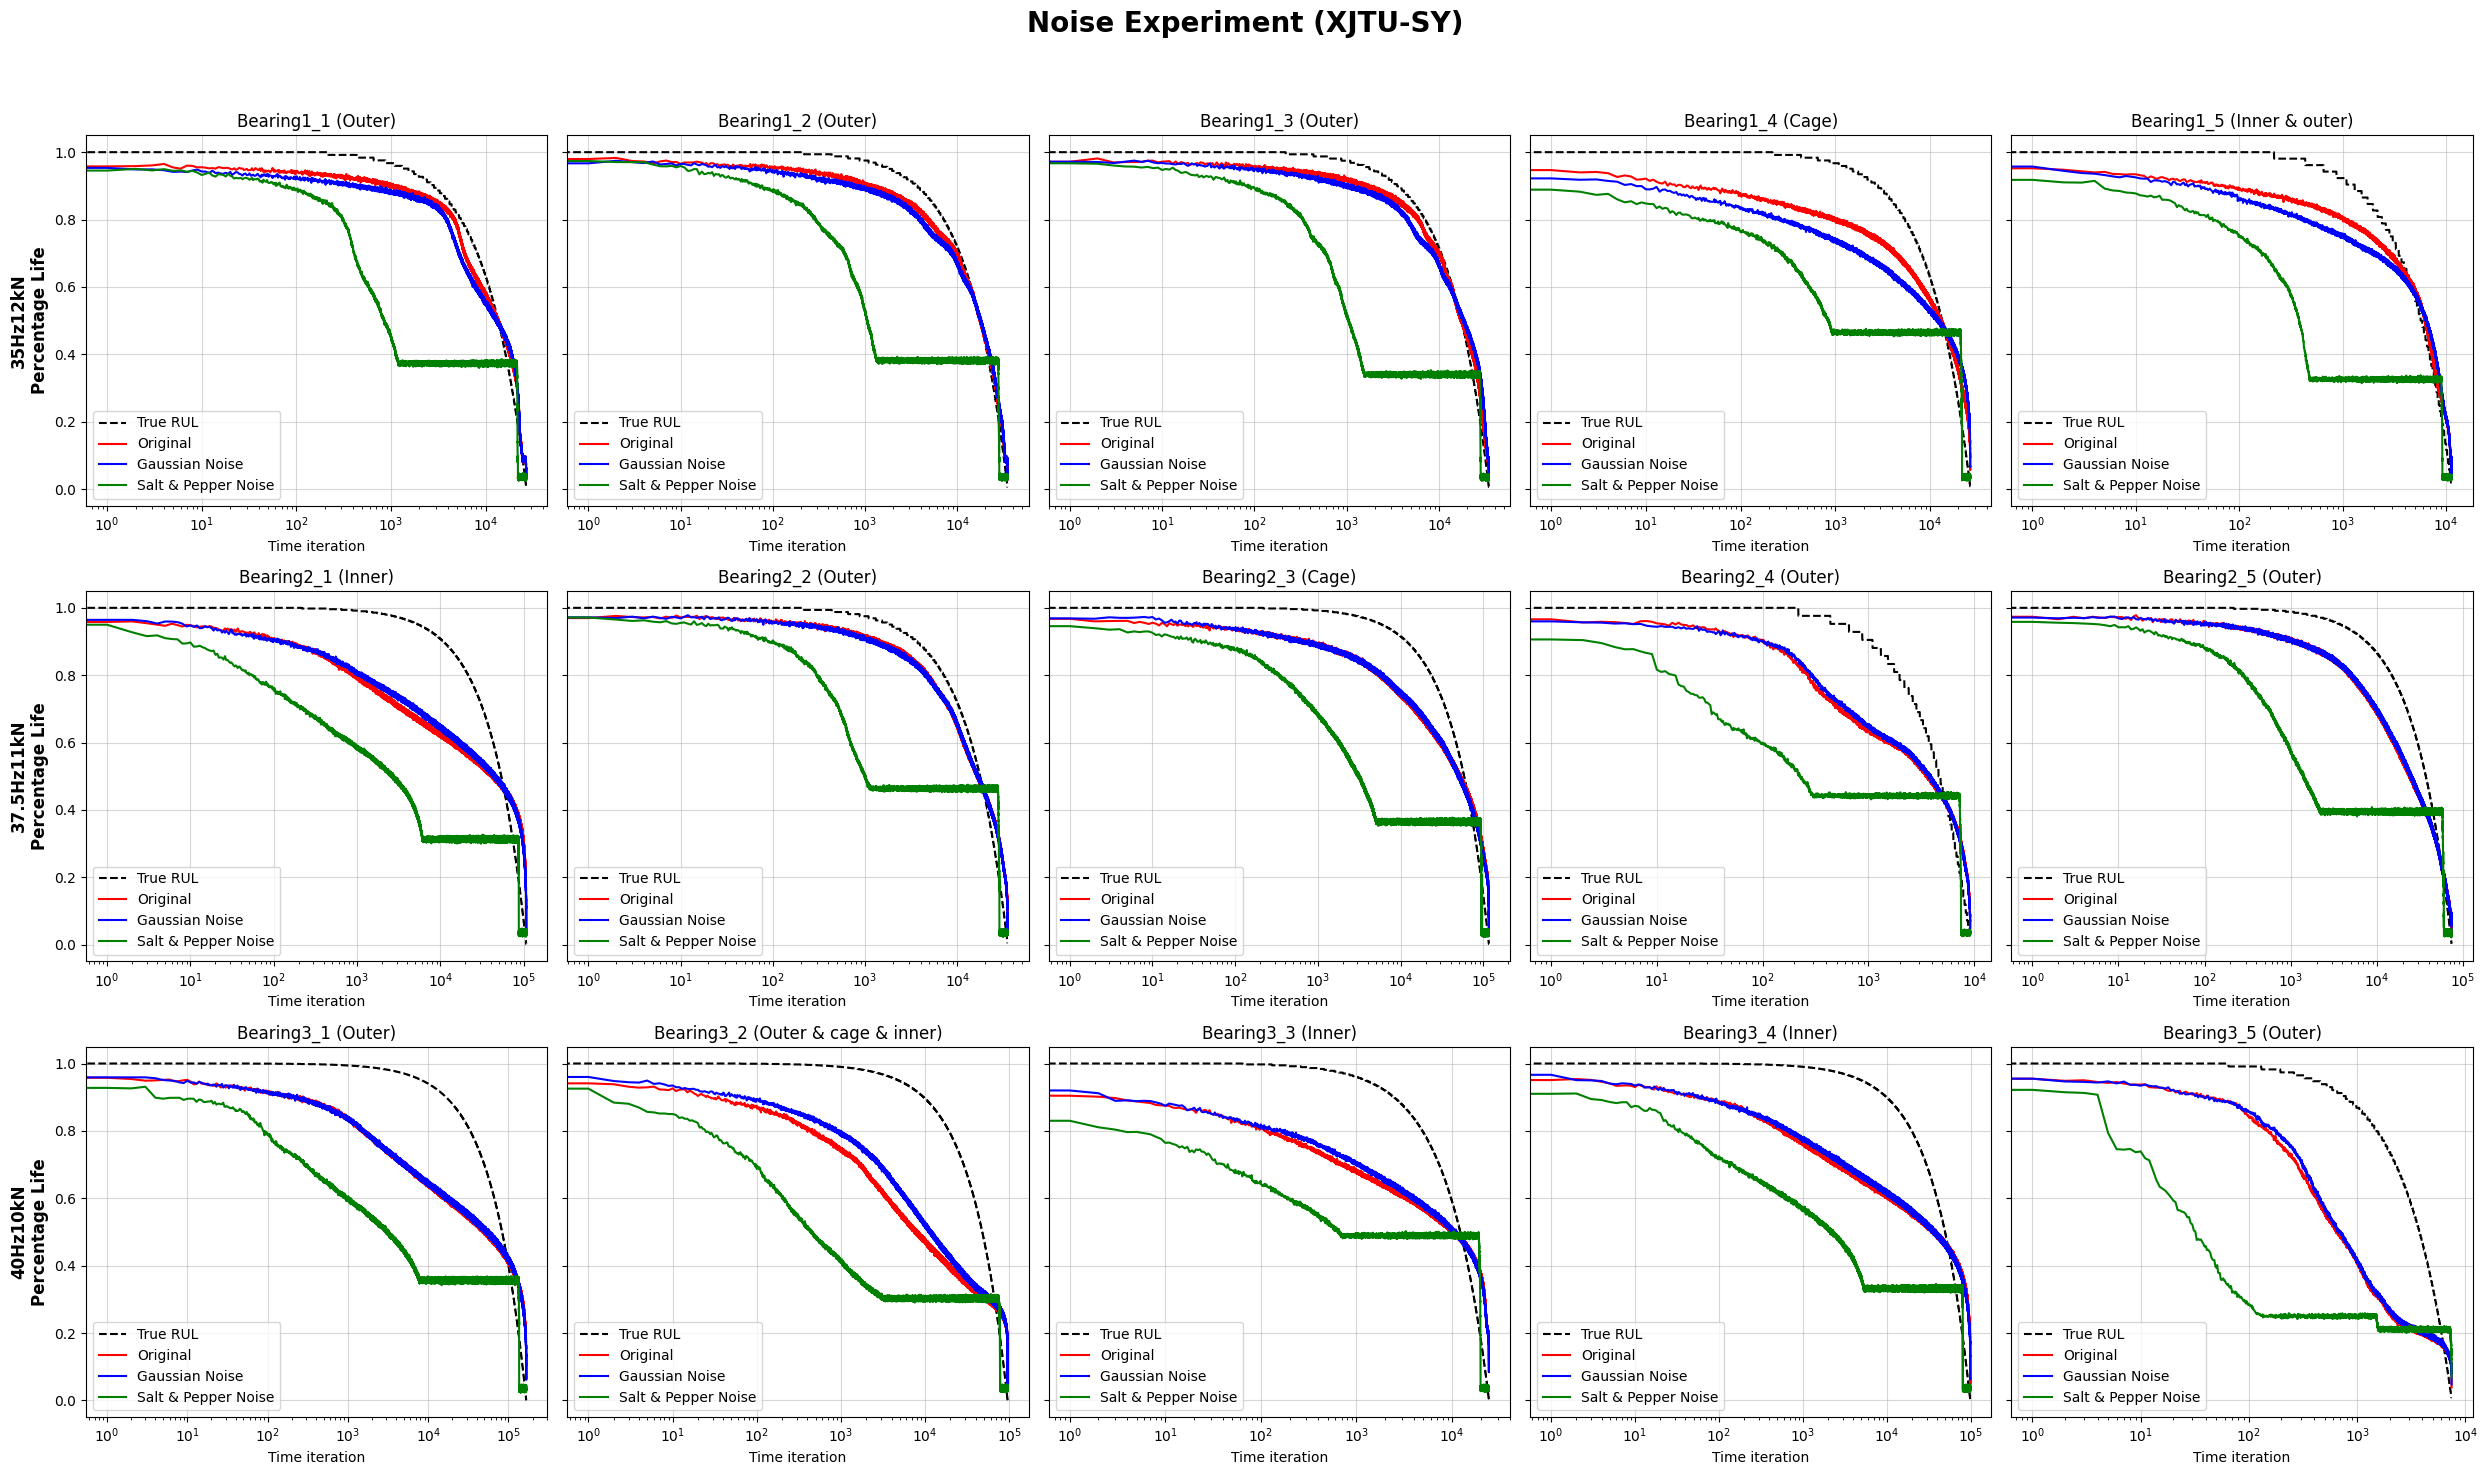

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model, load_model
from utils.preprocess import process_features
from ablation_CARLE import CARLE
import joblib

# Function to add Gaussian noise
def add_gaussian_noise(data, mean=0, std_dev=0.1):
    noise = np.random.normal(mean, std_dev, data.shape)
    return data + noise

# Function to add salt-and-pepper noise
def add_salt_and_pepper_noise(data, salt_prob=0.1, pepper_prob=0.1):
    noisy_data = data.copy()
    total_elements = data.size
    salt_count = int(salt_prob * total_elements)
    pepper_count = int(pepper_prob * total_elements)
    
    # Add salt noise
    salt_coords = np.random.randint(0, data.shape[0], salt_count)
    noisy_data[salt_coords] = np.max(data)
    
    # Add pepper noise
    pepper_coords = np.random.randint(0, data.shape[0], pepper_count)
    noisy_data[pepper_coords] = np.min(data)
    
    return noisy_data

# Bearings dictionary
bearings = {
    '35Hz12kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer'},
        {'name': 'Bearing1_2', 'failure': 'Outer'},
        {'name': 'Bearing1_3', 'failure': 'Outer'},
        {'name': 'Bearing1_4', 'failure': 'Cage'},
        {'name': 'Bearing1_5', 'failure': 'Inner & outer'},
    ],
    '37.5Hz11kN': [
        {'name': 'Bearing2_1', 'failure': 'Inner'},
        {'name': 'Bearing2_2', 'failure': 'Outer'},
        {'name': 'Bearing2_3', 'failure': 'Cage'},
        {'name': 'Bearing2_4', 'failure': 'Outer'},
        {'name': 'Bearing2_5', 'failure': 'Outer'},
    ],
    '40Hz10kN': [
        {'name': 'Bearing3_1', 'failure': 'Outer'},
        {'name': 'Bearing3_2', 'failure': 'Outer & cage & inner'},
        {'name': 'Bearing3_3', 'failure': 'Inner'},
        {'name': 'Bearing3_4', 'failure': 'Inner'},
        {'name': 'Bearing3_5', 'failure': 'Outer'},
    ]
}

# Directories
dir = os.getcwd()
time_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
feature_dir = os.path.join(dir, 'tf_features')

# Load models
carle_keras = CARLE()
carle_keras.load_weights(f'{weights_dir}/xjtu_CARLE_weights.h5')
carle_extractor = Model(inputs=carle_keras.input, outputs=carle_keras.get_layer(index=-2).output)
carle_regressor = joblib.load(f'{weights_dir}/xjtu_CARLE_skl.pkl')



# Visualization setup
plt.style.use('seaborn-v0_8-deep')
rows = len(bearings)
columns = max(len(bearing_list) for bearing_list in bearings.values())
fig, axes = plt.subplots(rows, columns, figsize=(25, 5 * rows), sharey=True)
fig.suptitle('Noise Experiment (XJTU-SY)', fontsize=20, fontweight='bold')

# Loop through bearings
for row, (condition, bearing_list) in enumerate(bearings.items()):
    for col in range(columns):
        if col < len(bearing_list):
            bearing_info = bearing_list[col]
            bearing = bearing_info['name']
            failure = bearing_info['failure']
            try:
                df = pd.read_csv(f'{feature_dir}/{bearing}_features.csv')
                # Process features
                horizontal_features = np.array(df['Horizontal'].apply(eval).tolist())
                xh = process_features(horizontal_features)
                vertical_features = np.array(df['Vertical'].apply(eval).tolist())
                xv = process_features(vertical_features)
                X = np.concatenate([xh, xv], axis=1)
                y_true = df['RUL'].values / np.max(df['RUL'].values)

                # Predictions with original data
                carle_X = carle_extractor.predict(X).squeeze()
                pred_carle = carle_regressor.predict(carle_X).squeeze()

                # Predictions with Gaussian noise applied to concatenated features
                X_gaussian = add_gaussian_noise(X)
                carle_X_gaussian = carle_extractor.predict(X_gaussian).squeeze()
                pred_gaussian = carle_regressor.predict(carle_X_gaussian).squeeze()

                # Predictions with salt-and-pepper noise applied to concatenated features
                X_sp = add_salt_and_pepper_noise(X)
                carle_X_sp = carle_extractor.predict(X_sp).squeeze()
                pred_sp = carle_regressor.predict(carle_X_sp).squeeze()

                # Sort predictions
                pred_carle = np.sort(pred_carle.squeeze())[::-1]
                pred_gaussian = np.sort(pred_gaussian.squeeze())[::-1]
                pred_sp = np.sort(pred_sp.squeeze())[::-1]

                # Add noise to predictions
                noise_carle = np.random.normal(0, 0.003, size=pred_carle.shape)
                noise_gaussian = np.random.normal(0, 0.003, size=pred_gaussian.shape)
                noise_sp = np.random.normal(0, 0.003, size=pred_sp.shape)
                pred_carle += noise_carle
                pred_gaussian += noise_gaussian
                pred_sp += noise_sp


                # Plot
                axes[row, col].plot(y_true, label='True RUL', color='black', linestyle='--')
                axes[row, col].plot(pred_carle, label='Original', color='red', linestyle='-')
                axes[row, col].plot(pred_gaussian, label='Gaussian Noise', color='blue', linestyle='-')
                axes[row, col].plot(pred_sp, label='Salt & Pepper Noise', color='green', linestyle='-')

                axes[row, col].set_title(f'{bearing} ({failure})')
                axes[row, col].grid(alpha=0.5)
                axes[row, col].legend(loc='best')
                axes[row, col].set_xlabel('Time iteration')

                axes[row, col].set_xscale('log')  # Use set_xscale instead of xscale
                if col == 0:
                    axes[row, col].set_ylabel(f'{condition}\nPercentage Life', fontsize=12, fontweight='bold')
            except Exception as e:
                print(f"Error processing {bearing}: {e}")
        else:
            axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Processing Time Analaysis

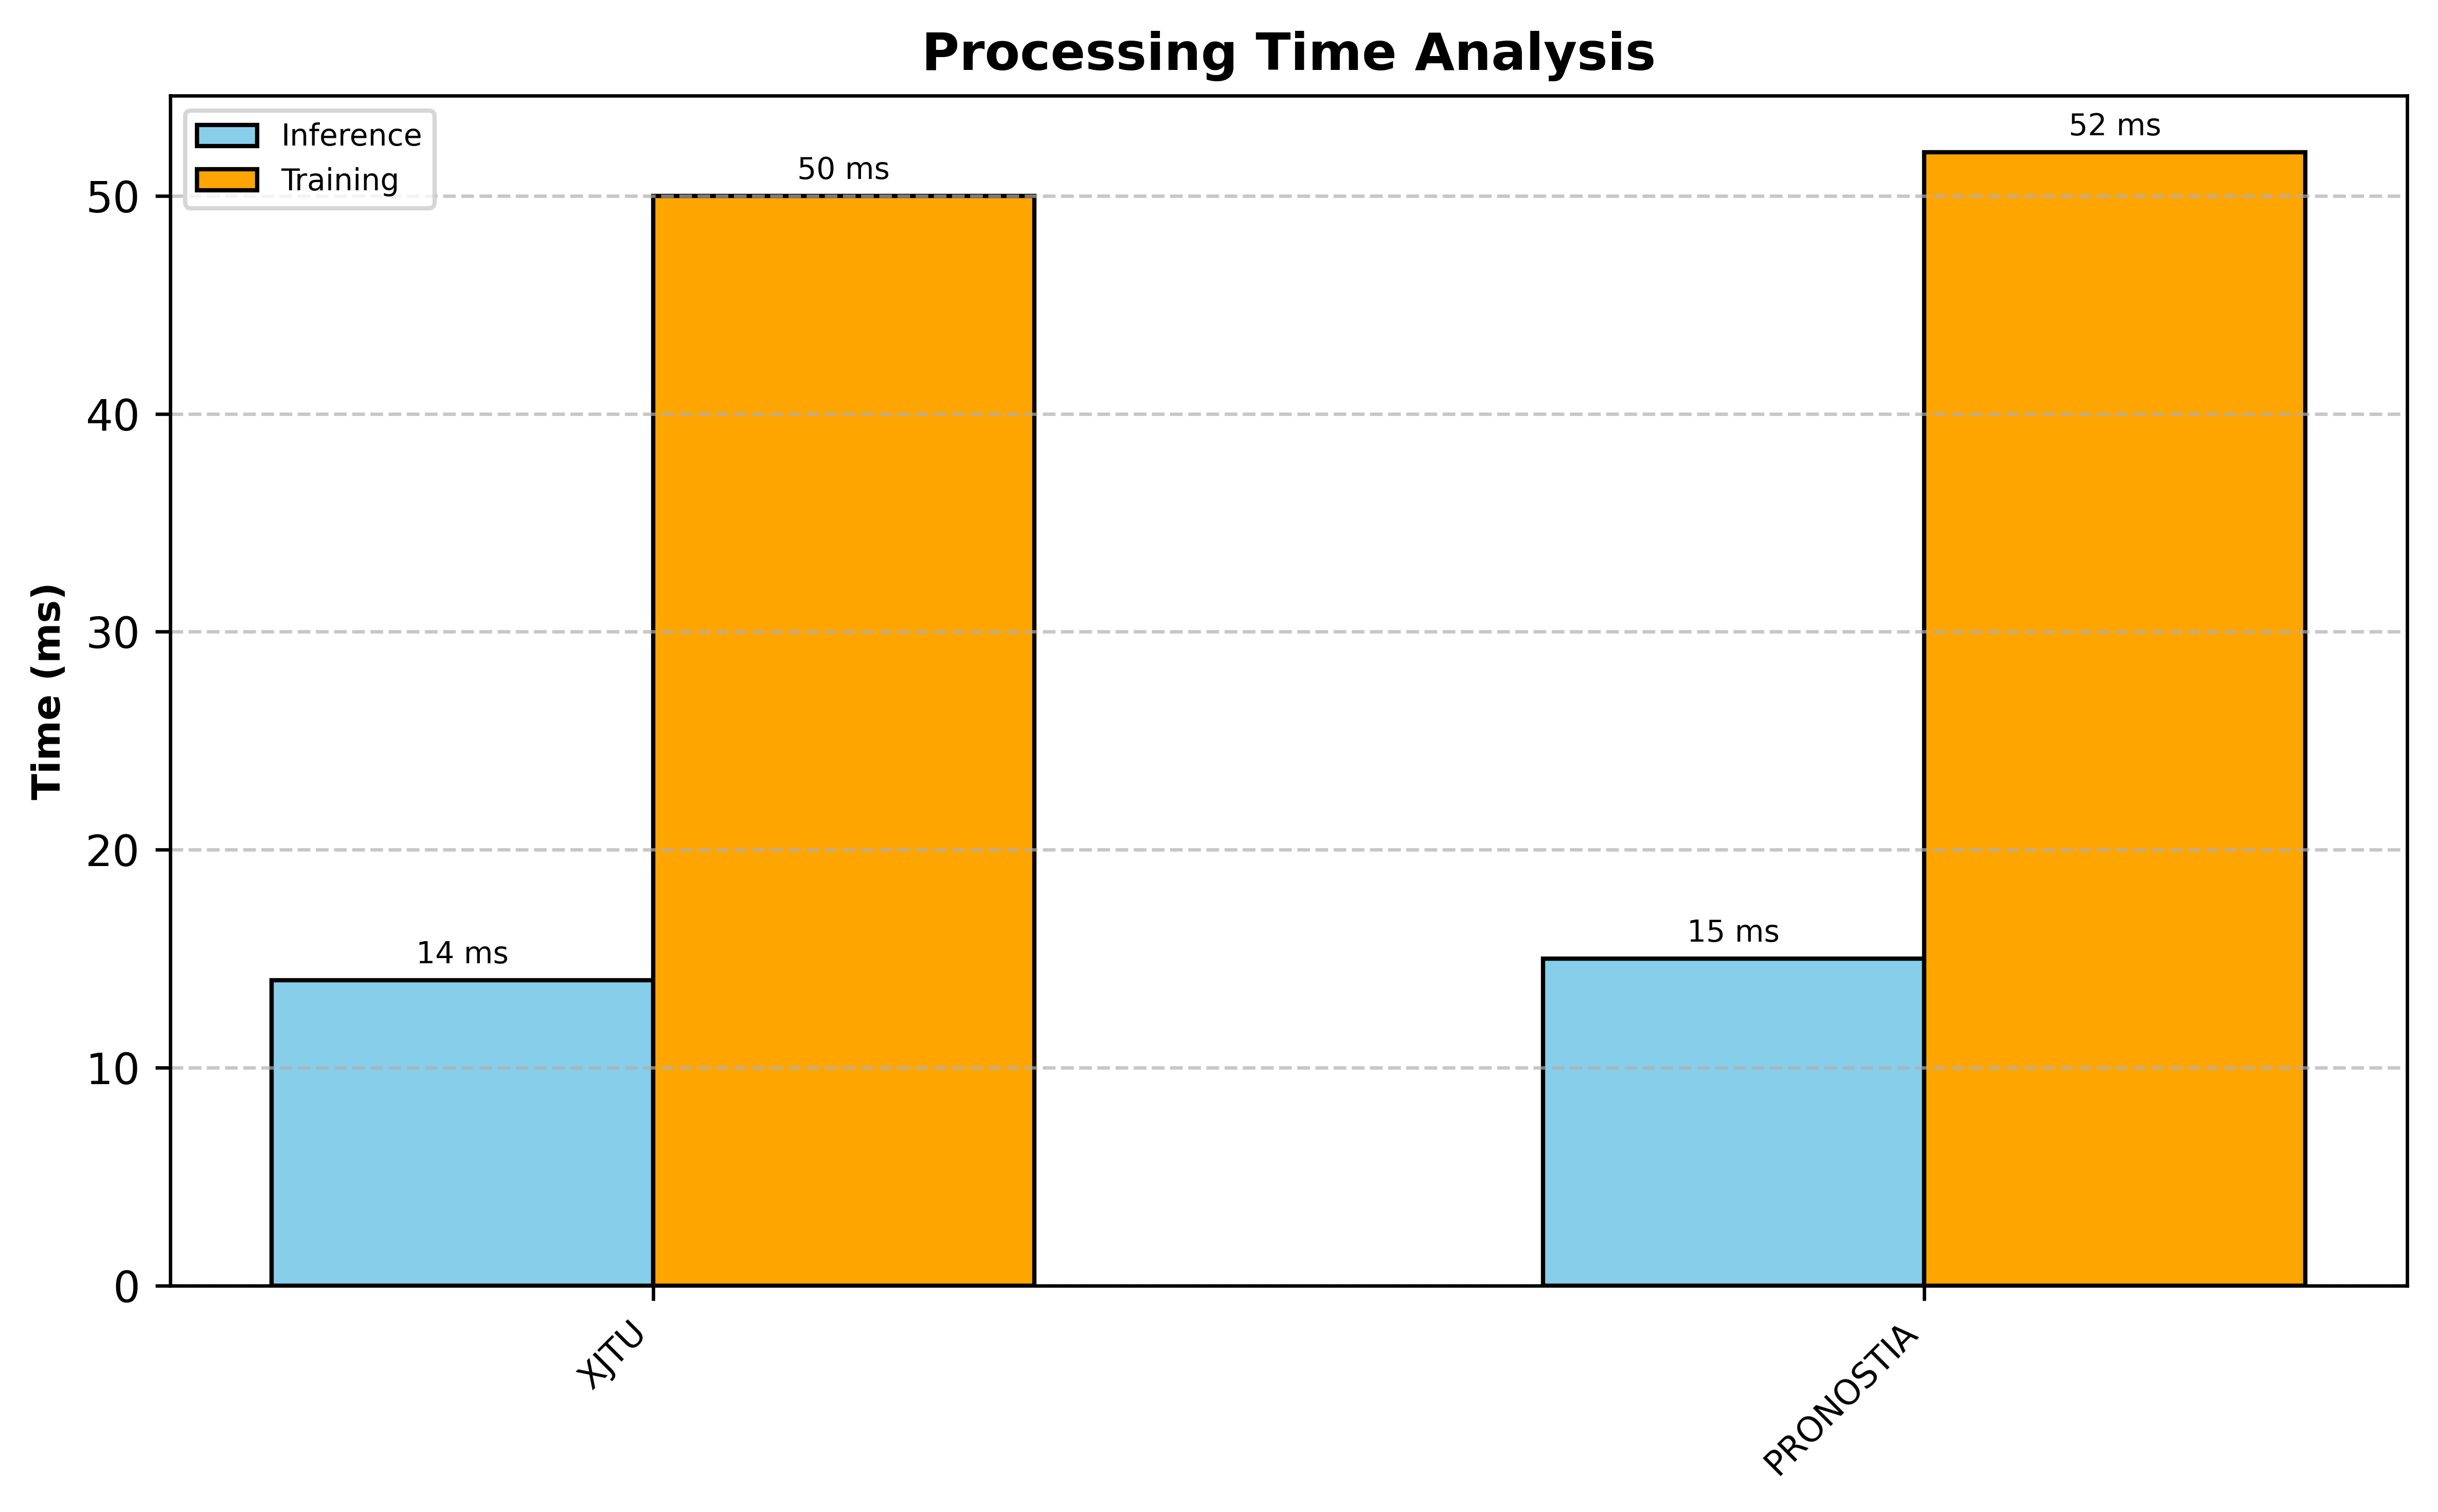

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

plt.style.use('seaborn-v0_8-deep')

# -----------------------------
# Data
# -----------------------------
models = ['XJTU', 'PRONOSTIA']
training = [50, 52]
inference = [14, 15]

x = np.arange(len(models))
width = 0.3

# -----------------------------
# Subplot setup
# -----------------------------
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=600)

# -----------------------------
# Time Analysis
# -----------------------------
bars_infer = ax.bar(x - width/2, inference, width, label='Inference', color='skyblue', edgecolor='black')
bars_train = ax.bar(x + width/2, training, width, label='Training', color='orange', edgecolor='black')

ax.set_title('Processing Time Analysis', fontweight='bold')
ax.set_ylabel('Time (ms)', fontsize=9, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(fontsize=7)

# Annotate bars
for bar, time in zip(bars_infer, inference):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            f'{time} ms', ha='center', va='bottom', fontsize=7)

for bar, time in zip(bars_train, training):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            f'{time} ms', ha='center', va='bottom', fontsize=7)

# -----------------------------
# Final layout and save
# -----------------------------
plots_dir = "./plots"
os.makedirs(plots_dir, exist_ok=True)
plt.tight_layout()
# plt.savefig(f"{plots_dir}/model_time_analysis.png", bbox_inches='tight', dpi=600)
plt.show()
